#Progetto Text Mining

Compito di classificazione del testo rispetto alle seguenti categorie:


*   Automotive
*   Patio, Lawn and Garden
*   Office Products
*   Toys_&_Games



Mount Drive

In [ ]:
import random
random.seed(2020)

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Import librerie

In [ ]:
!pip install contractions

In [ ]:
!pip install pyspellchecker

In [ ]:
import gzip
import numpy as np
import json
import pandas as pd
from sklearn import utils
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords, treebank
import contractions
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()
from spellchecker import SpellChecker
from itertools import chain
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


##Import dei dati dalla fonte Stanford



###Funzioni per accedere ai dati da formato JSON in Pandas Dataframe

In [ ]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

def tolist(stringa):
  stringa = stringa.replace("'", "")
  stringa = stringa.replace(",", "")
  stringa = stringa.replace("[", "")
  stringa = stringa.replace("]", "")
  stringa = stringa.split()
  return stringa

###Dati

In [ ]:
#Automotive
!wget "http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Automotive_5.json.gz"
df_automotive = getDF("/content/Automotive_5.json.gz")
!rm "/content/Automotive_5.json.gz"

--2020-08-29 09:26:07--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Automotive_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202890818 (193M) [application/octet-stream]
Saving to: ‘Automotive_5.json.gz’

Automotive_5.json.g 100%[===================>] 193.49M  18.5MB/s    in 11s     

2020-08-29 09:26:19 (17.2 MB/s) - ‘Automotive_5.json.gz’ saved [202890818/202890818]

time: 55.3 s


In [ ]:
#Toys_and_Games
!wget "http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Toys_and_Games_5.json.gz"
df_toys_and_games = getDF("/content/Toys_and_Games_5.json.gz")
!rm "/content/Toys_and_Games_5.json.gz"

--2020-08-29 09:27:02--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Toys_and_Games_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242925873 (232M) [application/octet-stream]
Saving to: ‘Toys_and_Games_5.json.gz’

Toys_and_Games_5.js 100%[===================>] 231.67M  19.9MB/s    in 13s     

2020-08-29 09:27:16 (18.3 MB/s) - ‘Toys_and_Games_5.json.gz’ saved [242925873/242925873]

time: 1min 3s


In [ ]:
#Office_Products
!wget "http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Office_Products_5.json.gz"
df_office_products = getDF("/content/Office_Products_5.json.gz")
!rm "/content/Office_Products_5.json.gz"

--2020-08-29 09:28:06--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Office_Products_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111685374 (107M) [application/octet-stream]
Saving to: ‘Office_Products_5.json.gz’

Office_Products_5.j 100%[===================>] 106.51M  20.0MB/s    in 6.3s    

2020-08-29 09:28:13 (16.9 MB/s) - ‘Office_Products_5.json.gz’ saved [111685374/111685374]

time: 32.2 s


In [ ]:
#Patio, Lawn and Garden	
!wget "http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Patio_Lawn_and_Garden_5.json.gz"
df_garden = getDF("/content/Patio_Lawn_and_Garden_5.json.gz")
!rm "/content/Patio_Lawn_and_Garden_5.json.gz"

--2020-08-29 09:28:39--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Patio_Lawn_and_Garden_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115147473 (110M) [application/octet-stream]
Saving to: ‘Patio_Lawn_and_Garden_5.json.gz’

Patio_Lawn_and_Gard 100%[===================>] 109.81M  20.3MB/s    in 6.3s    

2020-08-29 09:28:45 (17.4 MB/s) - ‘Patio_Lawn_and_Garden_5.json.gz’ saved [115147473/115147473]

time: 31.8 s


##Analisi del dataframe

###df_automotive

In [ ]:
df_automotive.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4.0,False,"05 1, 2015",A8WEXFRWX1ZHH,0209688726,{'Color:': ' AC'},Goldengate,"After I wrote the below review, the manufacturer contacted me and explained how to use this. Instead of the (current) picture on Amazon where the phone is placed vertically, you actually use the stand with the phone placed horizontally. Then the charge / sync cable goes through the hole and you can charge from the side. When used in landscape position this stand does make more sense so I'm upgrading this review from 2 stars to 4 stars (which I rarely do, but in this case user error) with a star off for lack of documentation. Manufacturer has said he will include directions and I would also encourage him to update the photos on Amazon with more examples of how this can be used. The wood quality is indeed good and it's a sturdy little stand. I'm trying to think of when I'd actually use this stand... perhaps for Facetime chats. I also think it would be useful for someone in an open office environment if they want to keep their phone on their desk and see alerts / notifications easily. Hope this updated review helps.\n\nORIGINAL REVIEW:\nI am throwing this stand in the garbage. While it's crafted of a nice wood, it is not functional as near as I can tell. It does not come with instructions and as you can see from the product description, even that is confusing since the English is poorly translated Chinese. The iPhone sits on the stand just fine, but when it's on the stand, there is no way the plug on the bottom will plug in -- the stand blocks it. If you turn the iPhone over, the plug is on the top, which just looks strange. And I'm not at all sure what the hole in the back of the stand is supposed to do. Also included are four plastic feet, again no instructions, so I affixed them to the bottom of the stand and it began to wobble.\n\nPerhaps someone else will figure out how to work this thing and post a review, but as far as I'm concerned, the out of the box experience was terrible.\n\nSorry, I cannot recommend.\n\nSample provided in exchange for an honest review.",Works well if you place phone in horizontally (landscape mode). Needs instructions / more photos here on Amazon,1430438400,NaN,NaN
1,1.0,True,"04 19, 2018",ABCA1A8E4DGV1,0209688726,{'Color:': ' Blue'},noe,It sucks barely picks up anything definitely not for cars or pretty much anything don't waste your money,sucks,1524096000,NaN,NaN
2,1.0,True,"04 16, 2018",A1NX8HM89FRQ32,0209688726,{'Color:': ' Black'},Eduard,"Well to write a short one, it blew 2 fuses of the car. Apparently this one demands more than 12v.",Defective,1523836800,NaN,NaN
3,3.0,True,"04 13, 2018",A1X77G023NY0KY,0209688726,{'Color:': ' CA'},Lauren,I have absolutely no memory of buying this but I'm going to review it so it goes away from my review stuff page. Looks cool! Probably works. Thumbs up.,Looks cool! Probably works,1523577600,NaN,NaN
4,5.0,True,"04 8, 2018",A3GK37JO2MGW6Q,0209688726,{'Color:': ' Black'},danny,it ok it does it job,Five Stars,1523145600,NaN,NaN


time: 54.1 ms


Si decide per questo dataframe e tutti quelli successivi di eliminare l'attributo style che indica la versione specifica del prodotto tramite un dizionario. Tutte le versioni dei prodotti verranno considerate ugualmente

In [ ]:
df_automotive.drop(columns = ["style", "image"], inplace = True)

time: 735 ms


Si valuta la presenza di recensioni duplicate

In [ ]:
df_automotive.duplicated().sum()

65433

time: 5.31 s


Si procede a filtrare il dataframe eliminando le recensioni duplicate

In [ ]:
df_automotive[df_automotive.duplicated(keep = False)]

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote
693,5.0,True,"11 12, 2015",A2N3LF6UXEI6SN,B00002243Z,Little guy,Good product ! Highly recommend !,Good product! Highly recommend,1447286400,NaN
694,5.0,True,"11 12, 2015",A2N3LF6UXEI6SN,B00002243Z,Little guy,Good product ! Highly recommend !,Good product! Highly recommend,1447286400,NaN
3175,1.0,True,"02 15, 2016",A2E9DVYU7OJGOD,B0000AXDFT,N. Velez V,"Good for covered Parking Lots, tested in a not covered place... forget it...",For covered places only....,1455494400,NaN
3176,1.0,True,"02 15, 2016",A2E9DVYU7OJGOD,B0000AXDFT,N. Velez V,"Good for covered Parking Lots, tested in a not covered place... forget it...",For covered places only....,1455494400,NaN
5289,5.0,True,"07 13, 2013",AQ8TEZMWBAJE7,B0000AY887,Paul Jones,"I like the Convert-A-Ball system. I have a number of trailers and three different ball sizes. Convert-A-Ball makes it very easy to adapt to all trailers. Care must be taken to have the ""stud"" with the hole facing front to rear and the ball installed with the pin inserted front to rear. This way the trailer prevents the pin from trying to remove itself. The vendor via Amazon was very pleasant and professional!",I like the Convert-A-Ball system,1373673600,NaN
...,...,...,...,...,...,...,...,...,...,...
1704736,5.0,True,"03 8, 2017",A175Z9YWNPSF1U,B01D1NP0PC,larry lawrence,As described,Five Stars,1488931200,NaN
1710106,5.0,True,"11 16, 2016",AV90FGVW5GQ3K,B01GJ6VMZA,Lee Otani,"Great product, fast shipping, exactly as described.",Five Stars,1479254400,NaN
1710107,5.0,True,"11 16, 2016",AV90FGVW5GQ3K,B01GJ6VMZA,Lee Otani,"Great product, fast shipping, exactly as described.",Five Stars,1479254400,NaN
1710108,4.0,True,"08 29, 2016",A1982UAIWBEOIB,B01GJ6VMZA,rich,good parts,Four Stars,1472428800,NaN


time: 5.11 s


In [ ]:
df_automotive = df_automotive[~df_automotive.duplicated()]

time: 5.46 s


Si controlla la porzione di valori nulli per ogni attributo

In [ ]:
df_automotive.isna().sum()/len(df_automotive)

overall           0.000000
verified          0.000000
reviewTime        0.000000
reviewerID        0.000000
asin              0.000000
reviewerName      0.000081
reviewText        0.000511
summary           0.000203
unixReviewTime    0.000000
vote              0.888472
dtype: float64

time: 1.45 s


Si procede ad eliminare tutte le recensioni senza testo

In [ ]:
df_automotive.dropna(subset=["reviewText"], inplace=True)
df_automotive

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote
0,4.0,False,"05 1, 2015",A8WEXFRWX1ZHH,0209688726,Goldengate,"After I wrote the below review, the manufacturer contacted me and explained how to use this. Instead of the (current) picture on Amazon where the phone is placed vertically, you actually use the stand with the phone placed horizontally. Then the charge / sync cable goes through the hole and you can charge from the side. When used in landscape position this stand does make more sense so I'm upgrading this review from 2 stars to 4 stars (which I rarely do, but in this case user error) with a star off for lack of documentation. Manufacturer has said he will include directions and I would also encourage him to update the photos on Amazon with more examples of how this can be used. The wood quality is indeed good and it's a sturdy little stand. I'm trying to think of when I'd actually use this stand... perhaps for Facetime chats. I also think it would be useful for someone in an open office environment if they want to keep their phone on their desk and see alerts / notifications easily. Hope this updated review helps.\n\nORIGINAL REVIEW:\nI am throwing this stand in the garbage. While it's crafted of a nice wood, it is not functional as near as I can tell. It does not come with instructions and as you can see from the product description, even that is confusing since the English is poorly translated Chinese. The iPhone sits on the stand just fine, but when it's on the stand, there is no way the plug on the bottom will plug in -- the stand blocks it. If you turn the iPhone over, the plug is on the top, which just looks strange. And I'm not at all sure what the hole in the back of the stand is supposed to do. Also included are four plastic feet, again no instructions, so I affixed them to the bottom of the stand and it began to wobble.\n\nPerhaps someone else will figure out how to work this thing and post a review, but as far as I'm concerned, the out of the box experience was terrible.\n\nSorry, I cannot recommend.\n\nSample provided in exchange for an honest review.",Works well if you place phone in horizontally (landscape mode). Needs instructions / more photos here on Amazon,1430438400,NaN
1,1.0,True,"04 19, 2018",ABCA1A8E4DGV1,0209688726,noe,It sucks barely picks up anything definitely not for cars or pretty much anything don't waste your money,sucks,1524096000,NaN
2,1.0,True,"04 16, 2018",A1NX8HM89FRQ32,0209688726,Eduard,"Well to write a short one, it blew 2 fuses of the car. Apparently this one demands more than 12v.",Defective,1523836800,NaN
3,3.0,True,"04 13, 2018",A1X77G023NY0KY,0209688726,Lauren,I have absolutely no memory of buying this but I'm going to review it so it goes away from my review stuff page. Looks cool! Probably works. Thumbs up.,Looks cool! Probably works,1523577600,NaN
4,5.0,True,"04 8, 2018",A3GK37JO2MGW6Q,0209688726,danny,it ok it does it job,Five Stars,1523145600,NaN
...,...,...,...,...,...,...,...,...,...,...
1711514,5.0,True,"06 19, 2018",A3H86E5N0F1Q5R,B01HJFDJ8S,John Jr,"Fast Shipping, Works Great!",Works Great!,1529366400,NaN
1711515,4.0,True,"08 23, 2017",AXH645B4SSAJY,B01HJFDJ8S,Brian.,"Fit isn't great, relays are very hard to press into connector and I am a mechanic!",Four Stars,1503446400,NaN
1711516,5.0,True,"08 8, 2017",AMGJLCCNVFB8,B01HJFDJ8S,John M.,I bought an auxiliary horn for my car and it needed to be run through a relay. These guys fit the bill perfectly.,I bought an auxiliary horn for my car and it ...,1502150400,NaN
1711517,5.0,True,"08 24, 2018",A1MJUNTX7CTR5U,B01HJI17Y8,JKPA,"Way better than stock. Nice bright and white. Super easy to install (from the top of the headlight, no need to take off the wheels and wheel wells). Also ordered the same exact ones for my fogs too.","NICE, BRIGHT AND WHITE",1535068800,NaN


time: 1.05 s


In [ ]:
df_automotive.isna().sum()/len(df_automotive)

overall           0.000000
verified          0.000000
reviewTime        0.000000
reviewerID        0.000000
asin              0.000000
reviewerName      0.000081
reviewText        0.000000
summary           0.000179
unixReviewTime    0.000000
vote              0.888458
dtype: float64

time: 1.58 s


Si analizza il numero di recensioni per utente per la categoria in analisi

In [ ]:
df_automotive.groupby("reviewerID").overall.count().sort_values(ascending = False)

reviewerID
A2QR9IXLMIDL5U    230
A11LNNUFT24J3O    167
A24FYZZXCMP44U    166
A1VQC0MWX3V260    151
A365PBEOWM7EI7    147
                 ... 
AL9963VBYGN8G     1  
A3M52WSL09Z648    1  
A1FO8WMW5YPP2X    1  
A130LL7BR8WV3Y    1  
A2U84IBYAY6P5P    1  
Name: overall, Length: 193637, dtype: int64

time: 1.15 s


Si conta il numero di prodotti recensiti

In [ ]:
len(df_automotive.groupby("asin"))

79437

time: 4 s


Si analizza quante recensioni per ogni prodotto

In [ ]:
df_automotive.groupby("asin").overall.count().sort_values(ascending = False)

asin
B000CITK8S    3250
B00480GYSA    2521
B000W20LKK    2519
B000M5W25E    1718
B002OUMVSS    1456
              ... 
B00128DZFQ    1   
B00152W42O    1   
B0010GCY34    1   
B0015MHAMI    1   
B0013GHAV2    1   
Name: overall, Length: 79437, dtype: int64

time: 575 ms


###df_garden

In [ ]:
df_garden.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,5.0,2,True,"12 11, 2011",AUVPE2KEXBJVT,9539723809,T. E. Kainz,"I don't spend a lot on my flags because they really get beat up. So I but the lesser quality figuring that they'll have to be replaced a couple of times a year anyways. The fact that this very inexpensive flag is still flying 8 months later pleases me well. It's up about 20 feet, 7/24, and sees winds averaging 5 to 10 mph on a 'normal' day with the occasional storm friont gusts reaching as high as 60+ mph. So far (8 months later) it's just now starting to show a little fraying on the ends. I'll be buying another shortly to have ready when this one finally gives in.",Good quality for the price,1323561600,NaN,NaN
1,5.0,NaN,True,"07 30, 2011",A2F6GES1MBOFXS,9539723809,BluesJamJim,"Super fast processing and shipping, if you are looking for flags look no more good quality product and a great company to do business with.",3'x5' Colorado State flag,1311984000,NaN,NaN
2,5.0,NaN,True,"05 4, 2016",A1SDVD3SZI1BAK,9539723809,Gabriel M Martinez,Great product. I would recommend this product. I would recommend this product.,Colorado Flag,1462320000,NaN,NaN
3,5.0,NaN,True,"11 2, 2015",A1ZQJ3KCSLUPR3,9539723809,RAJ THE FLASH,GREAT PRICE I LOVE MY STATE AND COUNTRY,RETIRED MILITARY,1446422400,NaN,NaN
4,5.0,NaN,True,"09 1, 2015",ANU8FBZM618M3,9539723809,James R. Mills,Great display flag for the den.,Five Stars,1441065600,NaN,NaN


time: 40.6 ms


Si decide per questo dataframe e tutti quelli successivi di eliminare l'attributo style che indica la versione specifica del prodotto tramite un dizionario. Tutte le versioni dei prodotti verranno considerate ugualmente

In [ ]:
df_garden.drop(columns = ["style", "image"], inplace = True)

time: 398 ms


Si valuta la presenza di recensioni duplicate

In [ ]:
df_garden.duplicated().sum()

47953

time: 2.45 s


Si procede a filtrare il dataframe eliminando le recensioni duplicate

In [ ]:
df_garden[df_garden.duplicated(keep = False)]

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
442,3.0,NaN,True,"07 15, 2015",A7W8P6V1K753T,B00002N674,DPC,Hose will kink easily!,Not the very best made!,1436918400
443,3.0,NaN,True,"07 15, 2015",A7W8P6V1K753T,B00002N674,DPC,Hose will kink easily!,Not the very best made!,1436918400
2238,5.0,NaN,True,"09 6, 2015",A3FWU0BOL1YYWN,B00002N8NI,Liesel D. Johnson,great,Five Stars,1441497600
2239,5.0,NaN,True,"09 6, 2015",A3FWU0BOL1YYWN,B00002N8NI,Liesel D. Johnson,great,Five Stars,1441497600
2243,2.0,NaN,False,"06 25, 2016",A43WXM31BDHWL,B00002N8NI,iheart2code,"I equipped my entire, three-zone backyard system with Rain Bird Sure Pop 600 sprinklers. They worked quite well for about 3 years, and then the riser seals started to go bad. The seals started to calcify and became warped, causing sprinklers to leak and/or not pop up at all. I tried cleaning the seals and soaking in CLR, but this did not solve the issue.\n\nOrdinarily, this would not be a problem. Buy replacement seals, install, and you're as good as new. HOWEVER, Rain Bird does not individually sell the riser seals, leaving you to purchase an entirely new sprinkler ($3-9) JUST to get a seal from the new unit. This would be a 4-5 star review if Rain Bird would individually seal riser seals.","Lasts for a few years, then needs to be replaced",1466812800
...,...,...,...,...,...,...,...,...,...,...
778230,5.0,NaN,True,"07 25, 2017",A3E9VGVU52LAOM,B00JSB0HCI,Amazon Customer,beautiful flowers,Five Stars,1500940800
781463,5.0,NaN,True,"12 24, 2017",A3L3EMHESU46QV,B00NGT8OOG,Keith,"Breat, gighly recommend","Breat, gighly recommend",1514073600
787356,5.0,NaN,True,"01 25, 2017",A2UV4ZSWD6ZEP3,B00WY67PYM,Dustin,Awesome- very fragile,Five Stars,1485302400
787357,5.0,NaN,True,"01 25, 2017",A2UV4ZSWD6ZEP3,B00WY67PYM,Dustin,Awesome- very fragile,Five Stars,1485302400


time: 2.27 s


In [ ]:
df_garden = df_garden[~df_garden.duplicated()]

time: 2.63 s


Si controlla la porzione di valori nulli per ogni attributo

In [ ]:
df_garden.isna().sum()/len(df_garden)

overall           0.000000
vote              0.845544
verified          0.000000
reviewTime        0.000000
reviewerID        0.000000
asin              0.000000
reviewerName      0.000036
reviewText        0.000233
summary           0.000200
unixReviewTime    0.000000
dtype: float64

time: 774 ms


Si procede ad eliminare tutte le recensioni senza testo

In [ ]:
df_garden.dropna(subset=["reviewText"], inplace=True)
df_garden

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,5.0,2,True,"12 11, 2011",AUVPE2KEXBJVT,9539723809,T. E. Kainz,"I don't spend a lot on my flags because they really get beat up. So I but the lesser quality figuring that they'll have to be replaced a couple of times a year anyways. The fact that this very inexpensive flag is still flying 8 months later pleases me well. It's up about 20 feet, 7/24, and sees winds averaging 5 to 10 mph on a 'normal' day with the occasional storm friont gusts reaching as high as 60+ mph. So far (8 months later) it's just now starting to show a little fraying on the ends. I'll be buying another shortly to have ready when this one finally gives in.",Good quality for the price,1323561600
1,5.0,NaN,True,"07 30, 2011",A2F6GES1MBOFXS,9539723809,BluesJamJim,"Super fast processing and shipping, if you are looking for flags look no more good quality product and a great company to do business with.",3'x5' Colorado State flag,1311984000
2,5.0,NaN,True,"05 4, 2016",A1SDVD3SZI1BAK,9539723809,Gabriel M Martinez,Great product. I would recommend this product. I would recommend this product.,Colorado Flag,1462320000
3,5.0,NaN,True,"11 2, 2015",A1ZQJ3KCSLUPR3,9539723809,RAJ THE FLASH,GREAT PRICE I LOVE MY STATE AND COUNTRY,RETIRED MILITARY,1446422400
4,5.0,NaN,True,"09 1, 2015",ANU8FBZM618M3,9539723809,James R. Mills,Great display flag for the den.,Five Stars,1441065600
...,...,...,...,...,...,...,...,...,...,...
798410,5.0,NaN,True,"09 6, 2018",AYE6G11DODB4A,B01HJ6NHD4,eml58,Great product at a great price and fast shipping,Five Stars,1536192000
798411,4.0,NaN,True,"08 27, 2018",A1X3HBLFQLPHYV,B01HJ6NHD4,Bob32927,Liked the cover. Covers well and should last a long time.,Good Cover for money,1535328000
798412,5.0,NaN,True,"10 3, 2018",A3FWXCF60VTX4Y,B01HJATY32,Dave Dunn Wilmer,"This is a nice quality grilling table where you can put all your grilling stuff and was very easy to assemble. I set it up next to\nmy gas grill and love it. Nice paper towel rod holder, stainless counter for your foods to be barbied, hanger hooks for barbi utencils and storage\nfor misc. items. Seems well made and I am happy with my purchase. Has the 2 wheels which makes it easy to move around. What more could you ask for! Just buy it and be happy!! No folks, my relative doesn't sell these!!! Just my honest review.",EASY TO ASSEMBLE AND WORKS WELL NEXT TO GRILL,1538524800
798413,5.0,NaN,True,"02 12, 2018",A3JNRP1X81U8KC,B01HJEAT3C,Bradley Henley,Pulley was shipped as described. Still have this pulley on my mower deck.,Shipped as described,1518393600


time: 554 ms


In [ ]:
df_garden.isna().sum()/len(df_garden)

overall           0.000000
vote              0.845532
verified          0.000000
reviewTime        0.000000
reviewerID        0.000000
asin              0.000000
reviewerName      0.000036
reviewText        0.000000
summary           0.000177
unixReviewTime    0.000000
dtype: float64

time: 758 ms


Si analizza il numero di recensioni per utente per la categoria in analisi

In [ ]:
df_garden.groupby("reviewerID").overall.count().sort_values(ascending = False)

reviewerID
A100WO06OQR8BQ    218
A2TM0K7HUH7SLC    173
A1JZFGZEZVWQPY    128
A2NOQ59T4NM0N3    120
A2QDOJFFLFGF18    111
                 ... 
AMAV2M2QTAEO7     1  
AK1A6OK0AFBIT     1  
A2BT0BYI43P031    1  
A4HET7OXYLFQT     1  
A1G7EMHZ3RNA3T    1  
Name: overall, Length: 103426, dtype: int64

time: 556 ms


Si conta il numero di prodotti recensiti

In [ ]:
len(df_garden.groupby("asin"))

32918

time: 1.7 s


Si analizza quante recensioni per ogni prodotto

In [ ]:
df_garden.groupby("asin").overall.count().sort_values(ascending = False)

asin
B00004R9VV    1481
B000E28UQU    1470
B000HCLLMM    1338
B0012QLVRM    1299
B00KNPAQ9M    982 
             ...  
B0015PDV2S    1   
B0015PFASQ    1   
B0015QWTOS    1   
B0016L35D6    1   
B0014SZOD0    1   
Name: overall, Length: 32918, dtype: int64

time: 299 ms


###df_office_products

In [ ]:
df_office_products.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4.0,True,"11 7, 2017",A2NIJTYWADLK57,0140503528,{'Format:': ' Board book'},cotton clay,kids like story BUT while i really wanted a board book this one is just so small. wish larger,"good story, small size book though",1510012800,NaN,NaN
1,4.0,True,"03 7, 2017",A2827D8EEURMP4,0140503528,{'Format:': ' Hardcover'},emankcin,"Bought this used and it came in great condition, almost like it had never been read. The story isn't as good as the original corduroy but my husband had this version as a child so had to add it to our daughter collection",Good,1488844800,NaN,NaN
2,5.0,True,"06 25, 2016",APB6087F4J09J,0140503528,{'Format:': ' Board book'},Starbucks Fan,Every story and book about Corduroy is Fantastic. This book is great and I bought all the Corduroy books for my 2 boys and now for their total of 5 children. You have to buy a Corduroy bear for everyone who has the books. Love to hold them while the stories are read.,Best Books for All Children,1466812800,NaN,NaN
3,5.0,True,"02 21, 2016",A2DHERRZIPFU7X,0140503528,{'Format:': ' Paperback'},Caitlyn Jacobson,"I purchased this book for my first grade classroom. I read the book to the students during a math lesson. The first day, I split the students into groups and had them count how many pockets they had all together. They recorded it on a chart and answered questions like: Who had the most? Who had the least? Choose two numbers and compare using <,>,=. The second day we referenced the book and compared pockets of the boys vs the girls. They again answered questions about the numbers. They loved it! Recommend!!",Great for Math!,1456012800,NaN,NaN
4,5.0,False,"08 2, 2015",A2XCLJRGFANRC,0140503528,{'Format:': ' Hardcover'},E. Ervin,"Having spent numerous years in an elementary school library, I can say with all honesty that the Corduroy books were great favorites for all the years I was there. A Pocket for Corduroy is a charming addition to anyone's collection. It is a very sweet story about the owner of Corduroy who leaves him in the laundry and has some difficulties retrieving him. Children can relate to that quite well. Getting him back is a good lesson in itself. Sewing the pocket on for him is delightful. It has a happy ending which is most enjoyable. Further note, when I read the Corduroy books to little people, I always tried to have an example of corduroy material with me - either on as pants, etc. Some of the children did not know what corduroy was. Five star book",Love Corduroy,1438473600,NaN,NaN


time: 41 ms


Si decide per questo dataframe e tutti quelli successivi di eliminare l'attributo style che indica la versione specifica del prodotto tramite un dizionario. Tutte le versioni dei prodotti verranno considerate ugualmente

In [ ]:
df_office_products.drop(columns = ["style", "image"], inplace = True)

time: 258 ms


Si valuta la presenza di recensioni duplicate

In [ ]:
df_office_products.duplicated().sum()

49842

time: 2.31 s


Si procede a filtrare il dataframe eliminando le recensioni duplicate

In [ ]:
df_office_products[df_office_products.duplicated(keep = False)]

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote
177,5.0,False,"12 29, 2016",A2I1WZLB8N6040,0439499887,Nick,arrived on time-kids loved it,Five Stars,1482969600,NaN
178,5.0,False,"12 29, 2016",A2I1WZLB8N6040,0439499887,Nick,arrived on time-kids loved it,Five Stars,1482969600,NaN
203,5.0,True,"06 9, 2016",AIYVMK30Q2G1L,0439499887,Monica Lambert,a gift and she loved it,Five Stars,1465430400,NaN
204,5.0,True,"06 9, 2016",AIYVMK30Q2G1L,0439499887,Monica Lambert,a gift and she loved it,Five Stars,1465430400,NaN
219,5.0,True,"12 27, 2015",A38X1A0N3BJ6EY,0439499887,Raymond K.,Granddaughter loves the book.,Five Stars,1451174400,NaN
...,...,...,...,...,...,...,...,...,...,...
792999,5.0,True,"07 7, 2018",A16O7PLZ0PIY7O,B00Z8D3DO4,Vitaliy Ryabenko,NICE,Five Stars,1530921600,NaN
793000,5.0,True,"02 15, 2018",A1M9OJXAU99GIL,B00Z8D3DO4,Amazon Customer,As advertised. Great capacity.,Great capacity.,1518652800,NaN
793001,5.0,True,"02 15, 2018",A1M9OJXAU99GIL,B00Z8D3DO4,Amazon Customer,As advertised. Great capacity.,Great capacity.,1518652800,NaN
798306,1.0,True,"06 9, 2018",A3ATBUZAKEUJDR,B01CYVGOAM,Katelyn R,"terribly made, the notebook came deformed and did not recover from the deformed shape. Love the color but unfortunately had to return.","terribly made, the notebook came deformed and did not ...",1528502400,NaN


time: 2.19 s


In [ ]:
df_office_products = df_office_products[~df_office_products.duplicated()]

time: 2.41 s


Si controlla la porzione di valori nulli per ogni attributo

In [ ]:
df_office_products.isna().sum()/len(df_office_products)

overall           0.000000
verified          0.000000
reviewTime        0.000000
reviewerID        0.000000
asin              0.000000
reviewerName      0.000177
reviewText        0.000269
summary           0.000163
unixReviewTime    0.000000
vote              0.889092
dtype: float64

time: 748 ms


Si procede ad eliminare tutte le recensioni senza testo

In [ ]:
df_office_products.dropna(subset=["reviewText"], inplace=True)
df_office_products

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote
0,4.0,True,"11 7, 2017",A2NIJTYWADLK57,0140503528,cotton clay,kids like story BUT while i really wanted a board book this one is just so small. wish larger,"good story, small size book though",1510012800,NaN
1,4.0,True,"03 7, 2017",A2827D8EEURMP4,0140503528,emankcin,"Bought this used and it came in great condition, almost like it had never been read. The story isn't as good as the original corduroy but my husband had this version as a child so had to add it to our daughter collection",Good,1488844800,NaN
2,5.0,True,"06 25, 2016",APB6087F4J09J,0140503528,Starbucks Fan,Every story and book about Corduroy is Fantastic. This book is great and I bought all the Corduroy books for my 2 boys and now for their total of 5 children. You have to buy a Corduroy bear for everyone who has the books. Love to hold them while the stories are read.,Best Books for All Children,1466812800,NaN
3,5.0,True,"02 21, 2016",A2DHERRZIPFU7X,0140503528,Caitlyn Jacobson,"I purchased this book for my first grade classroom. I read the book to the students during a math lesson. The first day, I split the students into groups and had them count how many pockets they had all together. They recorded it on a chart and answered questions like: Who had the most? Who had the least? Choose two numbers and compare using <,>,=. The second day we referenced the book and compared pockets of the boys vs the girls. They again answered questions about the numbers. They loved it! Recommend!!",Great for Math!,1456012800,NaN
4,5.0,False,"08 2, 2015",A2XCLJRGFANRC,0140503528,E. Ervin,"Having spent numerous years in an elementary school library, I can say with all honesty that the Corduroy books were great favorites for all the years I was there. A Pocket for Corduroy is a charming addition to anyone's collection. It is a very sweet story about the owner of Corduroy who leaves him in the laundry and has some difficulties retrieving him. Children can relate to that quite well. Getting him back is a good lesson in itself. Sewing the pocket on for him is delightful. It has a happy ending which is most enjoyable. Further note, when I read the Corduroy books to little people, I always tried to have an example of corduroy material with me - either on as pants, etc. Some of the children did not know what corduroy was. Five star book",Love Corduroy,1438473600,NaN
...,...,...,...,...,...,...,...,...,...,...
800352,5.0,True,"09 9, 2017",ACHG5QICJCS1F,B01HHLLLIO,Anky,Delivered on time and is as expected.,5 stars,1504915200,NaN
800353,5.0,True,"06 2, 2017",A1YB5J8SF6QX3L,B01HHLLLIO,DM,worked great.,good stuff,1496361600,NaN
800354,5.0,True,"04 29, 2017",A3N4O7L4HBYJX4,B01HHLLLIO,Verdant Treasures,"I used to score free UPS 4x6 labels. The black printing on them was always a little light and splotchy. I just figured my printer was old and the heating elements were worn out, since I bought the printer used online. These labels produced very dark blacks. They are also stickier - the UPS labels needed encouragement to stick well. Additionally, they tear off easier. Sometimes I would accidentally yank the printer off the table because the UPS labels were difficult to tear off. Also, when I compared these to the UPS labels, they are much whiter and brighter than the UPS labels, which seem a dingy off-white in comparison. I am so pleased with these. Customer for life. Thank you RBHK.",Couldn't be happier with these labels,1493424000,NaN
800355,5.0,True,"02 21, 2017",A2DR3CXSWWLYXY,B01HHLLLIO,C. F.,great,Five Stars,1487635200,NaN


time: 563 ms


In [ ]:
df_office_products.isna().sum()/len(df_garden)

overall           0.000000
verified          0.000000
reviewTime        0.000000
reviewerID        0.000000
asin              0.000000
reviewerName      0.000177
reviewText        0.000000
summary           0.000143
unixReviewTime    0.000000
vote              0.889124
dtype: float64

time: 774 ms


Si analizza il numero di recensioni per utente per la categoria in analisi

In [ ]:
df_office_products.groupby("reviewerID").overall.count().sort_values(ascending = False)

reviewerID
A3TTVIQ9RRHNIB    305
A3OXHLG6DIBRW8    247
A3N77PJ4KP3CJP    235
AVU1ILDDYW301     216
AC5HC2TJVWOFT     172
                 ... 
A1I5PIMDLQTO0Y    1  
A2QOD8166YRKE3    1  
A2RDG3NV6H0214    1  
AE41ATVZG6UIO     1  
A2YKOJD49BSJXJ    1  
Name: overall, Length: 101498, dtype: int64

time: 506 ms


Si conta il numero di prodotti recensiti

In [ ]:
len(df_office_products.groupby("asin"))

27965

time: 1.44 s


Si analizza quante recensioni per ogni prodotto

In [ ]:
df_office_products.groupby("asin").overall.count().sort_values(ascending = False)

asin
B00006IEEV    2247
B00A89YZ6S    1872
B00006IFEU    1867
B00006IFI5    1846
B00006JNJD    1729
              ... 
B0015S9L1A    1   
B0015S8IV4    1   
B0015S6CE4    1   
B0015S25LS    1   
B000XMI30O    1   
Name: overall, Length: 27965, dtype: int64

time: 291 ms


###df_toys_and_games

In [ ]:
df_toys_and_games.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,3,True,"10 6, 2013",A2LSCFZM2FBZK7,0486427706,{'Format:': ' Paperback'},Ginger,The stained glass pages are pretty cool. And it is nice how the black outlines are super dark and thick. And that the dragons aren't all fighting with the wizards.,Nice book,1381017600,NaN
1,5.0,9,True,"08 9, 2013",A3IXP5VS847GE5,0486427706,{'Format:': ' Paperback'},Dragonflies &amp; Autumn Leaves,"My 11 y.o. loved this...and so do I (you know I really bought this because I wanted to see the pictures myself...I'm just lucky enough to have someone I could justify buying it as a present for.)\nDragons and Wizards...says it all! With the wonderful see-through vellum like pages, that make it ""stained glass."" Color it with marker, or anything else really (colored pencil, watercolors maybe), and the light shining through the page makes it look luminous and gorgeous!\n\nEven the perfectionist that gets intimidated with art and drawing tends to find these stained glass books easy to get results they are happy with, so it tends to be an enjoyable and confidence building experience. :)",Great pictures,1376006400,NaN
2,5.0,NaN,True,"04 5, 2016",A1274GG1EB2JLJ,0486427706,{'Format:': ' Paperback'},barbara ann,"The pictures are great , I've done one and gave it to a friend of mine who likes dragons.","The pictures are great, I've done one and gave it to a ...",1459814400,NaN
3,5.0,3,True,"02 13, 2016",A30X5EGBYAZQQK,0486427706,{'Format:': ' Paperback'},Samantha,I absolutely love this book! Its translucent paper make it super fun to use. I have been using Paint Brush Markers and Sakura Gel Pens on it with excellent quality. The only thing that I would recommend is a blank white sheet of paper to make the lines easier to see.,So beautiful!,1455321600,NaN
4,5.0,NaN,True,"12 10, 2015",A3U6UNXLAUY6ZV,0486427706,{'Format:': ' Paperback'},CP in Texas,I love it!,Five Stars,1449705600,NaN


time: 42.8 ms


Si decide per questo dataframe e tutti quelli successivi di eliminare l'attributo style che indica la versione specifica del prodotto tramite un dizionario. Tutte le versioni dei prodotti verranno considerate ugualmente

In [ ]:
df_toys_and_games.drop(columns = ["style", "image"], inplace = True)

time: 519 ms


Si valuta la presenza di recensioni duplicate

In [ ]:
df_toys_and_games.duplicated().sum()

64308

time: 5.97 s


Si procede a filtrare il dataframe eliminando le recensioni duplicate

In [ ]:
df_toys_and_games[df_toys_and_games.duplicated(keep = False)]

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
581,4.0,NaN,True,"09 8, 2014",A2534XA4DU1H4Y,0963469150,Amazon Customer,All Good,Four Stars,1410134400
582,4.0,NaN,True,"09 8, 2014",A2534XA4DU1H4Y,0963469150,Amazon Customer,All Good,Four Stars,1410134400
2954,5.0,NaN,True,"11 30, 2016",A3771WYFXR8ZQG,1579823645,Peggy Perkins,Cute,Five Stars,1480464000
2955,5.0,NaN,True,"11 30, 2016",A3771WYFXR8ZQG,1579823645,Peggy Perkins,Cute,Five Stars,1480464000
4780,5.0,NaN,False,"07 23, 2013",A3PC0L6BU3ZF8T,1932188126,NJKramer,"My wife and I continuously return to Bananagrams for its originality and speed. Players are given several letters and make words out of the all the given existing letters upon which the player says, ""Peel."" Every player receives several new letter tiles until they are likewise used up in words and the player says, ""Peel."" The process continues until all the tiles from the draw pile are gone, when the first player to use all the letters says, ""Bananagrams"" instead of ""Peel."" Game over.\nThe game requires quick problem solving, a wide vocabulary, the ability to adapt, and the ability to start over if you can't fit in the newly acquired tiles. It's lots of fun amongst two people or a large group of friends; it doesn't become boring; and it is fast if you have a hankering for a quick word game! Any family or guest-entertainer needs it!",Bananafans,1374537600
...,...,...,...,...,...,...,...,...,...,...
1813906,5.0,NaN,True,"12 27, 2017",A2F7XNY6WYJ1KJ,B01B6DRJGW,JB47,Great puzzle.,Five Stars,1514332800
1813907,5.0,NaN,True,"12 27, 2017",A2F7XNY6WYJ1KJ,B01B6DRJGW,JB47,Great puzzle.,Five Stars,1514332800
1820574,5.0,NaN,True,"05 27, 2017",A2S9PECRFSZRTI,B01CVGVJ00,Amazon Customer,Who doesn't love Funko POP?!?!?,Five Stars,1495843200
1825821,5.0,NaN,True,"09 8, 2017",A7ADRYBEXXF0Y,B01FIJQKI8,V.Jay,nice,Five Stars,1504828800


time: 5.48 s


In [ ]:
df_toys_and_games = df_toys_and_games[~df_toys_and_games.duplicated()]

time: 6.09 s


Si controlla la porzione di valori nulli per ogni attributo

In [ ]:
df_toys_and_games.isna().sum()/len(df_toys_and_games)

overall           0.000000
vote              0.886427
verified          0.000000
reviewTime        0.000000
reviewerID        0.000000
asin              0.000000
reviewerName      0.000063
reviewText        0.000647
summary           0.000206
unixReviewTime    0.000000
dtype: float64

time: 1.58 s


Si procede ad eliminare tutte le recensioni senza testo

In [ ]:
df_toys_and_games.dropna(subset=["reviewText"], inplace=True)
df_toys_and_games

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,5.0,3,True,"10 6, 2013",A2LSCFZM2FBZK7,0486427706,Ginger,The stained glass pages are pretty cool. And it is nice how the black outlines are super dark and thick. And that the dragons aren't all fighting with the wizards.,Nice book,1381017600
1,5.0,9,True,"08 9, 2013",A3IXP5VS847GE5,0486427706,Dragonflies &amp; Autumn Leaves,"My 11 y.o. loved this...and so do I (you know I really bought this because I wanted to see the pictures myself...I'm just lucky enough to have someone I could justify buying it as a present for.)\nDragons and Wizards...says it all! With the wonderful see-through vellum like pages, that make it ""stained glass."" Color it with marker, or anything else really (colored pencil, watercolors maybe), and the light shining through the page makes it look luminous and gorgeous!\n\nEven the perfectionist that gets intimidated with art and drawing tends to find these stained glass books easy to get results they are happy with, so it tends to be an enjoyable and confidence building experience. :)",Great pictures,1376006400
2,5.0,NaN,True,"04 5, 2016",A1274GG1EB2JLJ,0486427706,barbara ann,"The pictures are great , I've done one and gave it to a friend of mine who likes dragons.","The pictures are great, I've done one and gave it to a ...",1459814400
3,5.0,3,True,"02 13, 2016",A30X5EGBYAZQQK,0486427706,Samantha,I absolutely love this book! Its translucent paper make it super fun to use. I have been using Paint Brush Markers and Sakura Gel Pens on it with excellent quality. The only thing that I would recommend is a blank white sheet of paper to make the lines easier to see.,So beautiful!,1455321600
4,5.0,NaN,True,"12 10, 2015",A3U6UNXLAUY6ZV,0486427706,CP in Texas,I love it!,Five Stars,1449705600
...,...,...,...,...,...,...,...,...,...,...
1828966,5.0,NaN,True,"01 19, 2018",A3RRY2TCWM3MWU,B01HJ4GZIU,ash,This was a huge hit. I had purchased this and other stuff as party favors. Kids and adults loved this. It was the first party favor to get over.,Huge hit,1516320000
1828967,1.0,NaN,True,"10 2, 2017",A2ZRCFLXI8J39O,B01HJ4GZIU,Laura,Ours didn't work! Only 3 worked out of the whole package and we had to 'operate' on them to get those to light up! Disappointed.,Don't buy!,1506902400
1828968,5.0,NaN,True,"10 5, 2018",A2IIP6L4PRAXVN,B01HJ8SCA0,JM,Simple plaything. Even my grandson cant break them. Yet.,Five Stars,1538697600
1828969,5.0,NaN,True,"08 12, 2018",ACJH8FKNLSXIQ,B01HJDFWDK,Steve Chen,These work well and are a nice change from the old batteries they replaced. These are able to hold a good charge all day for flying,Good value,1534032000


time: 1.13 s


In [ ]:
df_toys_and_games.isna().sum()/len(df_toys_and_games)

overall           0.000000
vote              0.886408
verified          0.000000
reviewTime        0.000000
reviewerID        0.000000
asin              0.000000
reviewerName      0.000064
reviewText        0.000000
summary           0.000188
unixReviewTime    0.000000
dtype: float64

time: 1.6 s


Si analizza il numero di recensioni per utente per la categoria in analisi

In [ ]:
df_toys_and_games.groupby("reviewerID").overall.count().sort_values(ascending = False)

reviewerID
AJGU56YG8G1DQ     733
A2HC9549CZAKNN    510
AVU1ILDDYW301     450
ALYZJ7W14YS26     416
A2QDOJFFLFGF18    403
                 ... 
APU16TZM7RBG4     1  
A2FLZFXF94PHT9    1  
AZ24XOC78K1MC     1  
AS0BHX27CNXA5     1  
A2AHTGSBRUE9QR    1  
Name: overall, Length: 208143, dtype: int64

time: 1.33 s


Si conta il numero di prodotti recensiti

In [ ]:
len(df_toys_and_games.groupby("asin"))

78772

time: 4.15 s


Si analizza quante recensioni per ogni prodotto

In [ ]:
df_toys_and_games.groupby("asin").overall.count().sort_values(ascending = False)

asin
B000YDDF6O    2444
B00WR5357G    2149
B00CS16EJU    1220
B007GE75HY    1195
B009T45XDW    1157
              ... 
B00134PJNA    1   
B000W3XGL0    1   
B0010VOJZU    1   
B000W4CEWG    1   
B0012ZLOL6    1   
Name: overall, Length: 78772, dtype: int64

time: 607 ms


##Unione dei dataframe in un unica collezione di recensioni

Si crea l'attributo target per identificare la categoria di appartenenza per ogni recensione

In [ ]:
df_automotive["target"] = "automotive"
df_garden["target"] = "garden"
df_office_products["target"] = "office"
df_toys_and_games["target"] = "toys"

time: 43.2 ms


Unione dei dataframe

In [ ]:
collection = pd.concat([df_automotive, df_garden, df_office_products, df_toys_and_games], axis = 0)
print("la lunghezza della collezione di recensioni è: " + str(len(collection)))

la lunghezza della collezione di recensioni è: 4909367
time: 5.98 s


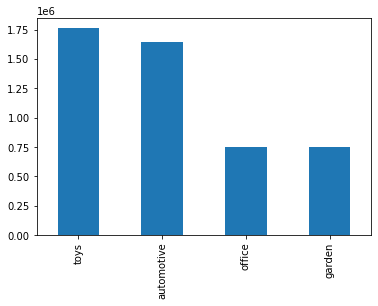

time: 538 ms


In [ ]:
collection.target.value_counts().plot.bar()

## Rimozione dell'URL all'interno del testo della recensione

Si considera la presenza di URL e tag HTML nel testo che devono essere eliminati prima di creare una rappresentazione formale del testo

In [ ]:
collection["url"] = collection["reviewText"].apply(lambda x : True if "http" in x else False)

time: 2.31 s


In [ ]:
collection[collection.url == True]

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,target,url
57,5.0,True,"09 13, 2016",A31H9F64M5O6G9,0209688726,Kevin,"<div id=""video-block-R1NV43RC3J8YCS"" class=""a-section a-spacing-small a-spacing-top-mini video-block""></div><input type=""hidden"" name="""" value=""https://images-na.ssl-images-amazon.com/images/I/D1j0gBUXIAS.mp4"" class=""video-url""><input type=""hidden"" name="""" value=""https://images-na.ssl-images-amazon.com/images/I/81zYCN1RrDS.png"" class=""video-slate-img-url"">&nbsp;I was hoping this would have enough suction to actually work in my car. I ran it through my entire car and it performed well. I was able to vacuum up dust on the dash and steering wheel. But what I liked was that I could get the dust out of the radio buttons and air vents with the brush attachment. I didn't try the air pump capability but this could come in handy if you get a flat on the road. So It will stay in my car for sure. I grabbed some sand and threw in on the floor to demonstrate how well it vacuums for you in case you were wondering too. But overall, I do recommend this vacuum cleaner and I would purchase this again. I will update my review it quits working within a few months. But so far it seems good.",Wrosk better than I expected!!!,1473724800,134,automotive,True
719,4.0,True,"02 22, 2014",A1DNT986OPD9Z5,B00002243Z,satisfied customer,"Purchased for rainy day, have not used them yet. These cables appear to be of good quality, and most important they seem to have a decent bite.\n\n Purchased with & fits perfectly into the ## Arsenal 5888 Cable Organizer ## http://www.amazon.com/s/ref=nb_sb_noss?url=search-alias%3Dautomotive&field-keywords=Arsenal%205888%20Cable%20Organizer",Satisfied with quality,1393027200,NaN,automotive,True
1622,4.0,True,"06 6, 2014",A11JDEMF0W38OE,B00005OWK2,Camp Runamok,"Since the Prius doesn't have a starter motor, I wanted a set of really light duty jumper cables. I got this instead. I figure I won't need much charge to light up the dash and get the car running, should I run my battery down. However, a friend brought up one caveat, which is that with keyless ignition, one can't always go power plug to power plug. So I got a set of these http://www.amazon.com/gp/product/B00065L2D8/ref=cm_cr_ryp_prd_ttl_sol_19 to go with this device. They are a nice set of light duty battery clips - perfect for the little battery in my Prius.",Good for a Prius,1402012800,2,automotive,True
2460,3.0,False,"08 1, 2015",A33DXDUPM6OE8V,B00009V3ZE,Matt M,"It works, but it's brown in color. This means while it did a lot to fix my scratch (smoothing) it also left a red-tan tint in the deeper part of the scratch I was polishing. Previous compounds of this brand I have used were white in color and left no visible marks on light-color paints (white, beige, baby-blue).\n\nI finally found a different Turtle Wax liquid compound that is white in color that worked much better for my needs, though it did not undo the discoloration.\nhttp://www.amazon.com/Turtle-Wax-T-415-Premium-Compound/dp/B000NMDFNY/ref=sr_1_4",Don't use on a white/light color car...,1438387200,8,automotive,True
2908,5.0,True,"05 26, 2016",A1NE4UO61C74KF,B0000AXDB3,Granimals70,"This thing worked amazingly for some of the clogged grease fittings on my twenty-year-old Toro Proline walk behind lawnmower; I had to use it several times on some of the fittings, but they all finally came clean. I used light machine oil, but understand from some reviewers here on Amazon and elsewhere that I could have used WD-40 or even mineral spirits. It worked great for me, and I intend to use it occasionally just to keep the fittings clean, as I had ignorantly and unintentionally let some of them go too long between maintenance and discovered the hard way that machines just won't work without proper maintenance.\n\nhttp://www.amazon.com/IPA-7862H-Grease-Joint-Rejuvenator/dp/B0000AXDB3?ie=UTF8&ref_=cm_cr_ryp_prd_ttl_sol_15",Amazing Little T

time: 3.57 s


In [ ]:
def noURL(text):
  #URL
  text = re.sub(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))",'', text)
  #TAG HTML
  text = re.sub('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', ' ', text)
  return text

time: 2.49 ms


In [ ]:
collection["text"] = collection.reviewText.apply(lambda x: noURL(x))

time: 1min 46s


## Aggiunta della lunghezza della recensione per ogni recensione (per lunghezza in caratteri e in token)

In [ ]:
collection["charlen"] = collection["reviewText"].apply(lambda x: len(x))
collection.to_csv("/gdrive/My Drive/Progetto_Text_Mining/Collection/preprocessing.csv")

time: 1min 37s


##Sampling per ottenere un numero di recensioni che permetta di impiegare un tempo ragionevole

In [ ]:
collection = pd.read_csv("/gdrive/My Drive/Progetto_Text_Mining/Collection/preprocessing.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
collection = collection.sort_values(by="charlen", ascending=False)

Si seleziona solo la recensione più lunga per ogni prodotto:

In [ ]:
collection = collection.groupby("asin").first()
collection
collection["asin"] = collection.index
collection.reset_index(drop=True, inplace=True)
collection.drop(columns="Unnamed: 0", inplace=True)

In [ ]:
collection.head()

,overall,verified,reviewTime,reviewerID,reviewerName,reviewText,summary,unixReviewTime,vote,target,url,text,charlen,asin
0,5.0,False,"08 2, 2015",A2XCLJRGFANRC,E. Ervin,"Having spent numerous years in an elementary school library, I can say with all honesty that the Corduroy books were great favorites for all the years I was there. A Pocket for Corduroy is a charming addition to anyone's collection. It is a very sweet story about the owner of Corduroy who leaves him in the laundry and has some difficulties retrieving him. Children can relate to that quite well. Getting him back is a good lesson in itself. Sewing the pocket on for him is delightful. It has a happy ending which is most enjoyable. Further note, when I read the Corduroy books to little people, I always tried to have an example of corduroy material with me - either on as pants, etc. Some of the children did not know what corduroy was. Five star book",Love Corduroy,1438473600,NaN,office,False,"Having spent numerous years in an elementary school library, I can say with all honesty that the Corduroy books were great favorites for all the years I was there. A Pocket for Corduroy is a charming addition to anyone's collection. It is a very sweet story about the owner of Corduroy who leaves him in the laundry and has some difficulties retrieving him. Children can relate to that quite well. Getting him back is a good lesson in itself. Sewing the pocket on for him is delightful. It has a happy ending which is most enjoyable. Further note, when I read the Corduroy books to little people, I always tried to have an example of corduroy material with me - either on as pants, etc. Some of the children did not know what corduroy was. Five star book",754,0140503528
1,4.0,False,"03 13, 2015",A45V752HS8PQI,Kindle Customer,"A bit pricy for a finger puppet (worth $7 or $8 max) so it is worth shopping around for her. However, she is very well-made and looks exactly like the character.even more than the picture shown. She has bigger eyes and little white tufts by her ears. She also has velcro on her feet and wings so I plan to hang her on the handle of my daughter's Easter basketwhich I know she will love as she adores the book so much.",Adorable Stellaluna,1426204800,2,toys,False,"A bit pricy for a finger puppet (worth $7 or $8 max) so it is worth shopping around for her. However, she is very well-made and looks exactly like the character.even more than the picture shown. She has bigger eyes and little white tufts by her ears. She also has velcro on her feet and wings so I plan to hang her on the handle of my daughter's Easter basketwhich I know she will love as she adores the book so much.",417,0152014764
2,4.0,False,"07 21, 2016",A2IK776FY6MEMG,Obi Wan,"I like this mini vacuum. It's not a replacement for a full size vacuum, but it also isn't huge and doesn't need a long extension cord to get to your car.\n\nI find this is good for minor clean up, but insufficient for a thorough deep cleaning. It has a decent amount of suction to it that doesn't struggle at all with small stones and other road grit that ends up in my floor mats. It pulls all the loose debris like that right up without batting an eyelash. It's the ground in dirt and debris this vacuum struggles with. It's not a lack of suction, it's a lack of a rotating brush head that you get on a Dirt Devil hand vac that digs into the carpet and knocks the dirt loose so it can be sucked up.\n\nThe brush attachment does a decent job of knocking some of that ground in grit loose with a little bit of elbow grease, but it's not like using a vac with a rotating brush head.\n\nThat said, this is great for getting up the loose dirt on the floor and cleaning out cup holders and the dirt and chunks of things that end up between and under your seats. So while it's not a deep cleaner, it's a good cleaner for in between the deep cleans.\n\nEverything fits in the bag, not just the vacuum.\n\nInitially I did think the filter was permanently affixed

Il risultato del sampling permette di ottenere 219092 recensioni, una per ogni prodotto. Sono così distribuite:

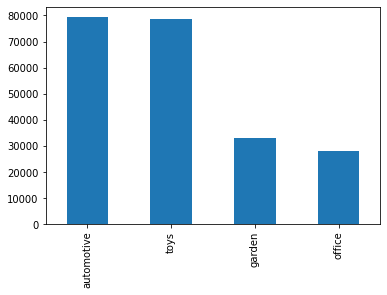

In [ ]:
collection.target.value_counts().plot.bar()

Si decide di mantere per ogni classe target un numero di recensioni pari alla dimensione della classe minore

In [ ]:
automotive = collection[0:27965]
garden = collection[79437:(79437 + 27965)]
office = collection[(79437 + 32918):((79437 + 32918) + 27965)]
toys = collection[((79437 + 78772 + 32918)):]
print("automotive: " + str(len(automotive)) + " garden: " + str(len(garden)) + " office: " + str(len(office)) + " toys: " + str(len(toys)))
collection = pd.concat([automotive, garden, office, toys], axis = 0)
print("Collection intera: " + str(len(collection)))

automotive: 27965 garden: 27965 office: 27965 toys: 27965
Collection intera: 111860


In [ ]:
collection.to_csv("/gdrive/My Drive/Progetto_Text_Mining/Collection/preprocessing.csv")

##Preprocessing

Si decide di mantenere solo le colonne del dataframe che risultano informative ed utili per lo scopo di rappresentazione del testo e di classificazione.

In [ ]:
collection = pd.read_csv("/gdrive/My Drive/Progetto_Text_Mining/Collection/preprocessing.csv")

In [ ]:
len(collection)

111860

In [ ]:
collection.drop(columns=["Unnamed: 0", "overall", "verified",	"reviewTime",	"reviewerID",	"reviewerName", "unixReviewTime",	"vote", "url"], inplace=True)
collection.head(3)

,reviewText,summary,target,text,charlen,asin
0,"Having spent numerous years in an elementary school library, I can say with all honesty that the Corduroy books were great favorites for all the years I was there. A Pocket for Corduroy is a charming addition to anyone's collection. It is a very sweet story about the owner of Corduroy who leaves him in the laundry and has some difficulties retrieving him. Children can relate to that quite well. Getting him back is a good lesson in itself. Sewing the pocket on for him is delightful. It has a happy ending which is most enjoyable. Further note, when I read the Corduroy books to little people, I always tried to have an example of corduroy material with me - either on as pants, etc. Some of the children did not know what corduroy was. Five star book",Love Corduroy,office,"Having spent numerous years in an elementary school library, I can say with all honesty that the Corduroy books were great favorites for all the years I was there. A Pocket for Corduroy is a charming addition to anyone's collection. It is a very sweet story about the owner of Corduroy who leaves him in the laundry and has some difficulties retrieving him. Children can relate to that quite well. Getting him back is a good lesson in itself. Sewing the pocket on for him is delightful. It has a happy ending which is most enjoyable. Further note, when I read the Corduroy books to little people, I always tried to have an example of corduroy material with me - either on as pants, etc. Some of the children did not know what corduroy was. Five star book",754,0140503528
1,"A bit pricy for a finger puppet (worth $7 or $8 max) so it is worth shopping around for her. However, she is very well-made and looks exactly like the character.even more than the picture shown. She has bigger eyes and little white tufts by her ears. She also has velcro on her feet and wings so I plan to hang her on the handle of my daughter's Easter basketwhich I know she will love as she adores the book so much.",Adorable Stellaluna,toys,"A bit pricy for a finger puppet (worth $7 or $8 max) so it is worth shopping around for her. However, she is very well-made and looks exactly like the character.even more than the picture shown. She has bigger eyes and little white tufts by her ears. She also has velcro on her feet and wings so I plan to hang her on the handle of my daughter's Easter basketwhich I know she will love as she adores the book so much.",417,0152014764
2,"I like this mini vacuum. It's not a replacement for a full size vacuum, but it also isn't huge and doesn't need a long extension cord to get to your car.\n\nI find this is good for minor clean up, but insufficient for a thorough deep cleaning. It has a decent amount of suction to it that doesn't struggle at all with small stones and other road grit that ends up in my floor mats. It pulls all the loose debris like that right up without batting an eyelash. It's the ground in dirt and debris this vacuum struggles with. It's not a lack of suction, it's a lack of a rotating brush head that you get on a Dirt Devil hand vac that digs into the carpet and knocks the dirt loose so it can be sucked up.\n\nThe brush attachment does a decent job of knocking some of that ground in grit loose with a little bit of elbow grease, but it's not like using a vac with a rotating brush head.\n\nThat said, this is great for getting up the loose dirt on the floor and cleaning out cup holders and the dirt and chunks of things that end up between and under your seats. So while it's not a deep cleaner, it's a good cleaner for in between the deep cleans.\n\nEverything fits in the bag, not just the vacuum.\n\nInitially I did think the filter was permanently affixed, which would have basically made this a one use machine. But it's just really stuck in the front cone that captures the dirt. I found that the extension attachment worked perfectly to loosen the filter. Just stick the extension attachment it in the front of the 

Si procede a svolgere la prima fase del preprocessing del testo

###Tokenization
Processo in cui il testo espresso in linguaggio naturale (in lingua inglese) viene suddiviso in token (sequenze di caratteri)

In [ ]:
def tokenization(testo):
  #Separazione della frase in token + eliminazione simboli e numeri
  tokens = [parola.lower() for frase in nltk.sent_tokenize(testo) for parola in nltk.word_tokenize(frase)]
  listatoken = []
  for token in tokens:
    if re.search('[a-zA-Z]', token): #espressione regolare che cerca nella stringa qualsiasi contenuto
      token = re.sub(r'[^\w]', ' ', token) # restituisce tutti i caratteri rimuovendo i simboli
      token = re.sub(r'[0-9]+', '', token) # restituisce tutti i caratteri rimuovendo i numeri
      listatoken.append(token)
  return listatoken

In [ ]:
collection["token"] = collection["text"].progress_apply(lambda x: tokenization(x))
collection.head(10)

,reviewText,summary,target,text,charlen,asin,token
0,"Having spent numerous years in an elementary school library, I can say with all honesty that the Corduroy books were great favorites for all the years I was there. A Pocket for Corduroy is a charming addition to anyone's collection. It is a very sweet story about the owner of Corduroy who leaves him in the laundry and has some difficulties retrieving him. Children can relate to that quite well. Getting him back is a good lesson in itself. Sewing the pocket on for him is delightful. It has a happy ending which is most enjoyable. Further note, when I read the Corduroy books to little people, I always tried to have an example of corduroy material with me - either on as pants, etc. Some of the children did not know what corduroy was. Five star book",Love Corduroy,office,"Having spent numerous years in an elementary school library, I can say with all honesty that the Corduroy books were great favorites for all the years I was there. A Pocket for Corduroy is a charming addition to anyone's collection. It is a very sweet story about the owner of Corduroy who leaves him in the laundry and has some difficulties retrieving him. Children can relate to that quite well. Getting him back is a good lesson in itself. Sewing the pocket on for him is delightful. It has a happy ending which is most enjoyable. Further note, when I read the Corduroy books to little people, I always tried to have an example of corduroy material with me - either on as pants, etc. Some of the children did not know what corduroy was. Five star book",754,0140503528,"[having, spent, numerous, years, in, an, elementary, school, library, i, can, say, with, all, honesty, that, the, corduroy, books, were, great, favorites, for, all, the, years, i, was, there, a, pocket, for, corduroy, is, a, charming, addition, to, anyone, s, collection, it, is, a, very, sweet, story, about, the, owner, of, corduroy, who, leaves, him, in, the, laundry, and, has, some, difficulties, retrieving, him, children, can, relate, to, that, quite, well, getting, him, back, is, a, good, lesson, in, itself, sewing, the, pocket, on, for, him, is, delightful, it, has, a, happy, ending, which, is, most, enjoyable, further, note, when, ...]"
1,"A bit pricy for a finger puppet (worth $7 or $8 max) so it is worth shopping around for her. However, she is very well-made and looks exactly like the character.even more than the picture shown. She has bigger eyes and little white tufts by her ears. She also has velcro on her feet and wings so I plan to hang her on the handle of my daughter's Easter basketwhich I know she will love as she adores the book so much.",Adorable Stellaluna,toys,"A bit pricy for a finger puppet (worth $7 or $8 max) so it is worth shopping around for her. However, she is very well-made and looks exactly like the character.even more than the picture shown. She has bigger eyes and little white tufts by her ears. She also has velcro on her feet and wings so I plan to hang her on the handle of my daughter's Easter basketwhich I know she will love as she adores the book so much.",417,0152014764,"[a, bit, pricy, for, a, finger, puppet, worth, or, max, so, it, is, worth, shopping, around, for, her, however, she, is, very, well made, and, looks, exactly, like, the, character even, more, than, the, picture, shown, she, has, bigger, eyes, and, little, white, tufts, by, her, ears, she, also, has, velcro, on, her, feet, and, wings, so, i, plan, to, hang, her, on, the, handle, of, my, daughter, s, easter, basketwhich, i, know, she, will, love, as, she, adores, the, book, so, much]"
2,"I like this mini vacuum. It's not a replacement for a full size vacuum, but it also isn't huge and doesn't need a long extension cord to get to your car.\n\nI find this is good for minor clean up, but insufficient for a thorough deep cleaning. It has a decent amount of suction to it that doesn't struggle at all with small stones and other road grit that ends up in my f

In [ ]:
import sys
sys.getrecursionlimit()
sys.setrecursionlimit(2000)

In [ ]:
collection.to_csv("/gdrive/My Drive/Progetto_Text_Mining/Collection/post_tokenization.csv")

###Normalization
Rappresentazione dei token scritti in formati diversi ma con il medesimo significato  in  una  unica  forma  comune,  evitando  che  si  presenti  lo  stesso  concetto con più forme differenti. Si valutano le contrazioni ma non lo spell-checking in quanto fornisce risultati deludenti.

In [ ]:
collection = pd.read_csv("/gdrive/My Drive/Progetto_Text_Mining/Collection/post_tokenization.csv", index_col = 0)

In [ ]:
def contraction(lista):
  for i in lista:
    i = contractions.fix(i, slang=True)
  return lista

In [ ]:
collection["token"] = collection["token"].progress_apply(lambda x: contraction(x))
collection.head()

,reviewText,summary,target,text,charlen,asin,token
0,"Having spent numerous years in an elementary school library, I can say with all honesty that the Corduroy books were great favorites for all the years I was there. A Pocket for Corduroy is a charming addition to anyone's collection. It is a very sweet story about the owner of Corduroy who leaves him in the laundry and has some difficulties retrieving him. Children can relate to that quite well. Getting him back is a good lesson in itself. Sewing the pocket on for him is delightful. It has a happy ending which is most enjoyable. Further note, when I read the Corduroy books to little people, I always tried to have an example of corduroy material with me - either on as pants, etc. Some of the children did not know what corduroy was. Five star book",Love Corduroy,office,"Having spent numerous years in an elementary school library, I can say with all honesty that the Corduroy books were great favorites for all the years I was there. A Pocket for Corduroy is a charming addition to anyone's collection. It is a very sweet story about the owner of Corduroy who leaves him in the laundry and has some difficulties retrieving him. Children can relate to that quite well. Getting him back is a good lesson in itself. Sewing the pocket on for him is delightful. It has a happy ending which is most enjoyable. Further note, when I read the Corduroy books to little people, I always tried to have an example of corduroy material with me - either on as pants, etc. Some of the children did not know what corduroy was. Five star book",754,0140503528,"['having', 'spent', 'numerous', 'years', 'in', 'an', 'elementary', 'school', 'library', 'i', 'can', 'say', 'with', 'all', 'honesty', 'that', 'the', 'corduroy', 'books', 'were', 'great', 'favorites', 'for', 'all', 'the', 'years', 'i', 'was', 'there', 'a', 'pocket', 'for', 'corduroy', 'is', 'a', 'charming', 'addition', 'to', 'anyone', ' s', 'collection', 'it', 'is', 'a', 'very', 'sweet', 'story', 'about', 'the', 'owner', 'of', 'corduroy', 'who', 'leaves', 'him', 'in', 'the', 'laundry', 'and', 'has', 'some', 'difficulties', 'retrieving', 'him', 'children', 'can', 'relate', 'to', 'that', 'quite', 'well', 'getting', 'him', 'back', 'is', 'a', 'good', 'lesson', 'in', 'itself', 'sewing', 'the', 'pocket', 'on', 'for', 'him', 'is', 'delightful', 'it', 'has', 'a', 'happy', 'ending', 'which', 'is', 'most', 'enjoyable', 'further', 'note', 'when', 'i', 'read', 'the', 'corduroy', 'books', 'to', 'little', 'people', 'i', 'always', 'tried', 'to', 'have', 'an', 'example', 'of', 'corduroy', 'material', 'with', 'me', 'either', 'on', 'as', 'pants', 'etc', 'some', 'of', 'the', 'children', 'did', 'not', 'know', 'what', 'corduroy', 'was', 'five', 'star', 'book']"
1,"A bit pricy for a finger puppet (worth $7 or $8 max) so it is worth shopping around for her. However, she is very well-made and looks exactly like the character.even more than the picture shown. She has bigger eyes and little white tufts by her ears. She also has velcro on her feet and wings so I plan to hang her on the handle of my daughter's Easter basketwhich I know she will love as she adores the book so much.",Adorable Stellaluna,toys,"A bit pricy for a finger puppet (worth $7 or $8 max) so it is worth shopping around for her. However, she is very well-made and looks exactly like the character.even more than the picture shown. She has bigger eyes and little white tufts by her ears. She also has velcro on her feet and wings so I plan to hang her on the handle of my daughter's Easter basketwhich I know she will love as she adores the book so much.",417,0152014764,"['a', 'bit', 'pricy', 'for', 'a', 'finger', 'puppet', 'worth', 'or', 'max', 'so', 'it', 'is', 'worth', 'shopping', 'around', 'for', 'her', 'however', 'she', 'is', 'very', 'well made', 'and', 'looks', 'exactly', 'like', 'the', 'character even', 'more', 'than', 'the', 'picture', 'shown', 'she', 'has', 'bigger', 'eyes', 'and', 'little', 'white', 'tufts', 'b

In [ ]:
collection.to_csv("/gdrive/My Drive/Progetto_Text_Mining/Collection/post_normalization.csv")

Tentativo spell checking

In [ ]:
#spell = SpellChecker()
#
#def spell_correct(token):
#  for i in token:
#    i = spell.correction(i).lower()
#    print(i)
#    #return sptext

#spell_correct(["'nt"])
#spell_correct(["nt"])

#collection["token"] = collection["token"].apply(lambda x: spell_correct(x))

In [ ]:
#collection.to_csv("/gdrive/My Drive/Progetto_Text_Mining/Collection/post_normalization2.csv")

###Lemmatization
Trasformazione del token in un lemma a seguito dell'analisi morfologica della parola. Consiste nella base morfologica da cui si originano le varie declinazioni di ogni parola.

In [ ]:
collection_lemma = pd.read_csv("/gdrive/My Drive/Progetto_Text_Mining/Collection/post_normalization.csv", index_col=0)

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatization(token):
  token = nltk.pos_tag(token)
  for i in range(len(token)):
    token[i] = [token[i][0], get_wordnet_pos(token[i][1])]
    token[i] = wordnet_lemmatizer.lemmatize(token[i][0], token[i][1])
  return token


def get_wordnet_pos(uni):
    if uni.startswith('ADJ'):
        return "a"
    if uni.startswith('ADP'):
        return "n"    
    elif uni.startswith('V'):
        return "v"
    elif uni.startswith('N'):
        return "n"
    elif uni.startswith('R'):
        return "r"
    else:
        return 'n'

#pos = ["hello", "my", "name", "is", "Paolo"]
#pos2 = ["you", "are", "welcome", "my", "friend"]
#lemmatization(pos2)

In [ ]:
def tolist(stringa):
  stringa = stringa.replace("'", "")
  stringa = stringa.replace(",", "")
  stringa = stringa.replace("[", "")
  stringa = stringa.replace("]", "")
  stringa = stringa.split()
  return stringa

In [ ]:
collection_lemma["lemma"] = collection_lemma["token"].progress_apply(lambda x: lemmatization(tolist(x)))

In [ ]:
collection_lemma.to_csv("/gdrive/My Drive/Progetto_Text_Mining/Collection/post_lemmatization.csv")

###Stemming
Riduzione del token alla radice del termine secondo alcune regole e pattern predefiniti.

In [ ]:
collection_stem = pd.read_csv("/gdrive/My Drive/Progetto_Text_Mining/Collection/post_normalization.csv")

In [ ]:
stemmer = SnowballStemmer(language="english")

def stemming(token):
  tmp = []
  for i in token:
    tmp.append(stemmer.stem(i))
  return tmp

def tolist(stringa):
  stringa = stringa.replace("'", "")
  stringa = stringa.replace(",", "")
  stringa = stringa.replace("[", "")
  stringa = stringa.replace("]", "")
  stringa = stringa.split()
  return stringa

stemming(["fabulous", "better", "strongly"])

['fabul', 'better', 'strong']

In [ ]:
collection_stem["stem"] = collection_stem["token"].progress_apply(lambda x: stemming(tolist(x)))
collection_stem.head(3)

In [ ]:
collection_stem.to_csv("/gdrive/My Drive/Progetto_Text_Mining/Collection/post_stemming.csv")

###Stopwords
Analisi dell'utilizzo delle parole per entrambi le collezioni ed eliminazione delle parole "stopwords"

In [ ]:
collection_stem = pd.read_csv("/gdrive/My Drive/Progetto_Text_Mining/Collection/post_stemming.csv")
collection_lemma = pd.read_csv("/gdrive/My Drive/Progetto_Text_Mining/Collection/post_lemmatization.csv")

Eliminazione delle parole frequenti in base alla lista delle stopwords inglesi, con aggiunta dei termini di dominio troppo frequenti.

In [ ]:
stemmer = SnowballStemmer(language="english")
stopwords_lemma = nltk.corpus.stopwords.words('english')
stopwords_stem = nltk.corpus.stopwords.words('english')
stopwords = nltk.corpus.stopwords.words('english')
domain_words = ["product", "purchase", "amazon", "shipping", "review", "prime", "now", "nt", "buy", "price",
                "package", "service", "order", "fee", "item", "received", "customer", "seller",
                "reseller", "specs", "satisfy"]

def stemming(token):
  tmp = []
  for i in token:
    tmp.append(stemmer.stem(i))
  return tmp

def tolist(stringa):
  stringa = stringa.replace("'", "")
  stringa = stringa.replace(",", "")
  stringa = stringa.replace("[", "")
  stringa = stringa.replace("]", "")
  stringa = stringa.split()
  return stringa

In [ ]:
def eliminasw(tokens, stopwords):
  lista = []
  for i in tokens:
    if i not in stopwords:
      lista.append(i)
  return lista

def keeptoken(tokens, stopwords):
  lista = []
  for i in tokens:
    if i in stopwords:
      lista.append(i)
  return lista

def lemmatization(token):
  token = nltk.pos_tag(token)
  for i in range(len(token)):
    token[i] = [token[i][0], get_wordnet_pos(token[i][1])]
    token[i] = wordnet_lemmatizer.lemmatize(token[i][0], token[i][1])
  return token

wordnet_lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(uni):
    if uni.startswith('ADJ'):
        return "a"
    if uni.startswith('ADP'):
        return "n"    
    elif uni.startswith('V'):
        return "v"
    elif uni.startswith('N'):
        return "n"
    elif uni.startswith('R'):
        return "r"
    else:
        return 'n'


def tolist(stringa):
  stringa = stringa.replace("'", "")
  stringa = stringa.replace(",", "")
  stringa = stringa.replace("[", "")
  stringa = stringa.replace("]", "")
  stringa = stringa.split()
  return stringa

In [ ]:
domain_lemma = []
domain_stem = []
for i in domain_words:
  domain_lemma.append(lemmatization(tolist(i)))
domain_lemma = list(chain.from_iterable(domain_lemma))

for i in domain_words:
  domain_stem.append(stemming(tolist(i)))
domain_stem = list(chain.from_iterable(domain_stem))

print(domain_words)
print(domain_lemma)
print(domain_stem)
stopwords_lemma.extend(domain_lemma)
stopwords_stem.extend(domain_stem)

['product', 'purchase', 'amazon', 'shipping', 'review', 'prime', 'now', 'nt', 'buy', 'price', 'package', 'service', 'order', 'fee', 'item', 'received', 'customer', 'seller', 'reseller', 'specs', 'satisfy']
['product', 'purchase', 'amazon', 'shipping', 'review', 'prime', 'now', 'nt', 'buy', 'price', 'package', 'service', 'order', 'fee', 'item', 'receive', 'customer', 'seller', 'reseller', 'spec', 'satisfy']
['product', 'purchas', 'amazon', 'ship', 'review', 'prime', 'now', 'nt', 'buy', 'price', 'packag', 'servic', 'order', 'fee', 'item', 'receiv', 'custom', 'seller', 'resel', 'spec', 'satisfi']


####Lemma

In [ ]:
collection_lemma["lemmanosw"] = collection_lemma["lemma"].progress_apply(lambda x: eliminasw(tolist(x), stopwords_lemma))

In [ ]:
collection_lemma.to_csv("/gdrive/My Drive/Progetto_Text_Mining/Collection/post_stopwords_lemma.csv")

####Stem

In [ ]:
collection_stem["stemnosw"] = collection_stem["stem"].progress_apply(lambda x: eliminasw(tolist(x), stopwords_stem))

In [ ]:
collection_stem.to_csv("/gdrive/My Drive/Progetto_Text_Mining/Collection/post_stopwords_stem.csv")

####Eliminazione stopwords contestuali in base alla frequenza di occorrenza nei documenti

In [ ]:
def creacorpus(serie):
  vocabolario = []
  for i in serie:
    vocabolario.append(i)
  #flatten
  return list(chain.from_iterable(vocabolario))

#####Lemma

In [ ]:
frequenzelemma = creacorpus(collection_lemma["lemmanosw"])

In [ ]:
counterlemma = Counter(frequenzelemma)
counterlemma.most_common()

[('n', 112547),
 ('one', 93488),
 ('use', 90290),
 ('get', 84501),
 ('like', 66210),
 ('make', 65517),
 ('would', 58774),
 ('well', 52608),
 ('work', 50200),
 ('look', 48369),
 ('go', 45851),
 ('time', 44043),
 ('great', 41513),
 ('good', 40584),
 ('come', 39482),
 ('also', 37117),
 ('little', 36572),
 ('need', 35203),
 ('set', 34551),
 ('really', 33589),
 ('take', 33571),
 ('year', 32661),
 ('much', 30530),
 ('fit', 29939),
 ('love', 29718),
 ('back', 28954),
 ('see', 27958),
 ('put', 27911),
 ('even', 27821),
 ('two', 27289),
 ('think', 27150),
 ('light', 26693),
 ('find', 26651),
 ('want', 26633),
 ('old', 25968),
 ('thing', 25930),
 ('could', 25530),
 ('play', 25212),
 ('say', 25206),
 ('part', 25097),
 ('quality', 24447),
 ('first', 23853),
 ('way', 23559),
 ('new', 23216),
 ('give', 22883),
 ('car', 22533),
 ('piece', 22305),
 ('color', 22162),
 ('still', 21966),
 ('try', 21916),
 ('easy', 21651),
 ('keep', 21621),
 ('side', 21126),
 ('toy', 21002),
 ('hold', 20080),
 ('small', 1

In [ ]:
len(counterlemma)

77459

In [ ]:
vocabolario = pd.DataFrame.from_dict(counterlemma, orient="index").reset_index()
vocabolario = vocabolario.rename(columns={"index":"word", 0:"frequency"})
vocabolario = vocabolario.sort_values(by="frequency", ascending=False)
vocabolario.head()

,word,frequency
91,n,112547
156,one,93488
139,use,90290
28,get,84501
63,like,66210


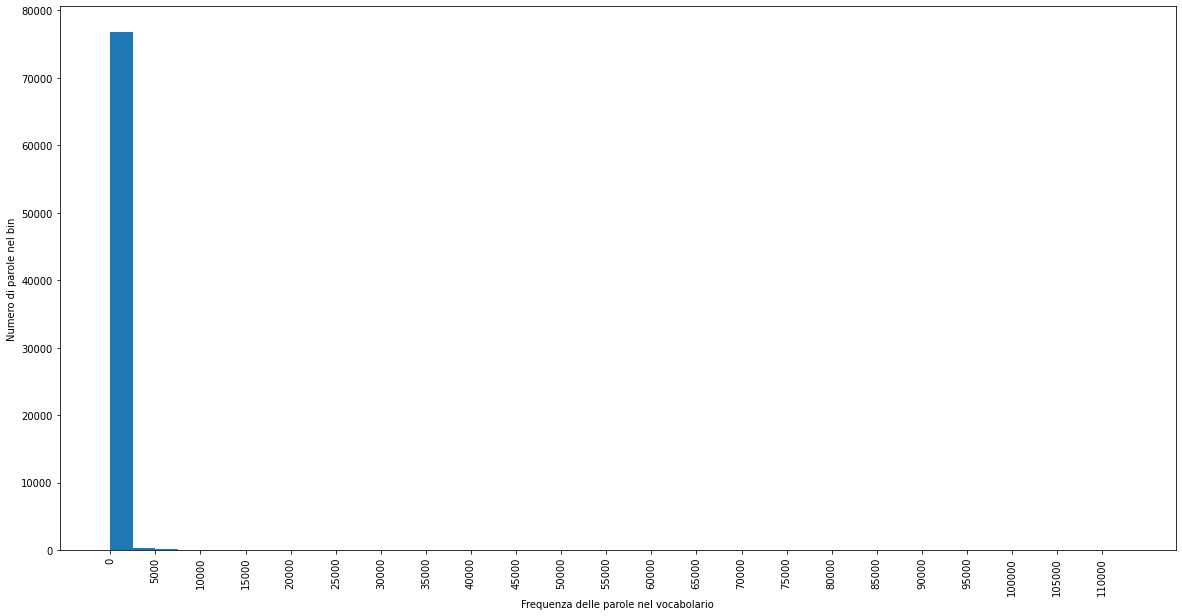

In [ ]:
plt.figure(figsize=(20, 10))
plt.hist(vocabolario.frequency, bins=range(0, vocabolario.frequency.max(), 2500))
plt.xticks(ticks = range(0, vocabolario.frequency.max(), 5000), rotation=90)
plt.xlabel("Frequenza delle parole nel vocabolario")
plt.ylabel("Numero di parole nel bin")
plt.show()

In [ ]:
mean = vocabolario.frequency.mean()
median = vocabolario.frequency.median()
print(mean, median)

116.76758026827096 2.0


In [ ]:
len(vocabolario[(vocabolario.frequency > 2) & (vocabolario.frequency < 10000)])

34410

In [ ]:
vocabolario = vocabolario[(vocabolario.frequency > 2) & (vocabolario.frequency < 10000)]

Si procede a filtrare tutti i lemma che sono troppo frequenti o troppo poco frequenti nel vocabolario, poichè non possiedono un elevato potere discriminante. Inoltre si riduce la sparsità della matrice.

In [ ]:
include = []
for i in vocabolario.word:
  include.append(i)
include = set(include)

In [ ]:
print("Il numero di lemma che vengono elminati dal vocabolario della collection è pari a : " + str(len(counterlemma) - len(include)))

Il numero di lemma che vengono elminati dal vocabolario della collection è pari a : 43049


In [ ]:
collection_lemma["lemmanosw2"] = collection_lemma.lemmanosw.progress_apply(lambda x: keeptoken(x, include))

In [ ]:
collection_lemma.to_csv("/gdrive/My Drive/Progetto_Text_Mining/Collection/post_stopwords_lemma_filtro.csv")

#####Stem

In [ ]:
frequenzestem = creacorpus(collection_stem["stemnosw"])

In [ ]:
counterstem = Counter(frequenzestem)
counterstem.most_common()

[('n', 112529),
 ('use', 93743),
 ('one', 93489),
 ('like', 69373),
 ('get', 63706),
 ('would', 58775),
 ('veri', 58023),
 ('work', 50648),
 ('look', 48477),
 ('well', 45497),
 ('time', 44712),
 ('great', 41986),
 ('make', 41329),
 ('good', 40821),
 ('onli', 38008),
 ('also', 37117),
 ('littl', 36582),
 ('set', 36153),
 ('need', 35361),
 ('realli', 33589),
 ('doe', 33264),
 ('becaus', 33208),
 ('year', 32789),
 ('go', 31868),
 ('fit', 31657),
 ('love', 30602),
 ('much', 30530),
 ('back', 29645),
 ('even', 28631),
 ('put', 27909),
 ('come', 27630),
 ('two', 27286),
 ('light', 27204),
 ('want', 26706),
 ('ani', 26281),
 ('instal', 26086),
 ('play', 26022),
 ('old', 26002),
 ('thing', 25930),
 ('could', 25530),
 ('part', 25229),
 ('made', 24537),
 ('color', 24496),
 ('qualiti', 24448),
 ('first', 23942),
 ('way', 23559),
 ('new', 23228),
 ('see', 23152),
 ('nice', 23001),
 ('car', 22547),
 ('piec', 22309),
 ('tri', 22295),
 ('replac', 22288),
 ('still', 21967),
 ('easi', 21661),
 ('take',

In [ ]:
len(counterstem)

60202

In [ ]:
vocabolario2 = pd.DataFrame.from_dict(counterstem, orient="index").reset_index()
vocabolario2 = vocabolario2.rename(columns={"index":"word", 0:"frequency"})
vocabolario2 = vocabolario2.sort_values(by="frequency", ascending=False)
vocabolario2.head()

,word,frequency
92,n,112529
140,use,93743
158,one,93489
64,like,69373
29,get,63706


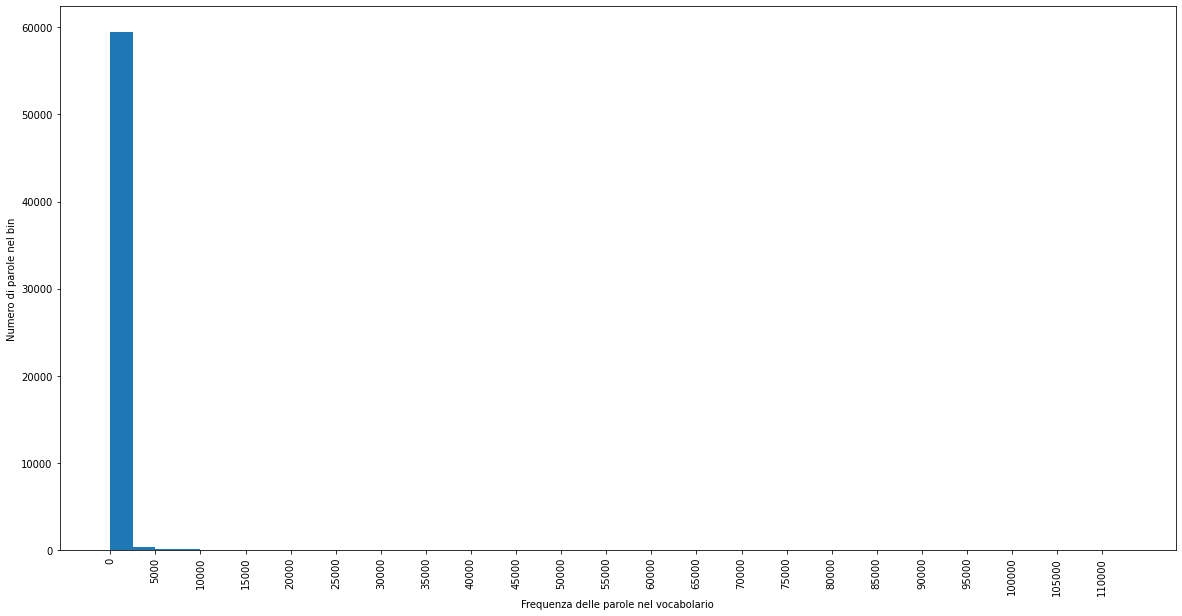

In [ ]:
plt.figure(figsize=(20, 10))
plt.hist(vocabolario2.frequency, bins=range(0, vocabolario2.frequency.max(), 2500))
plt.xticks(ticks = range(0, vocabolario2.frequency.max(), 5000), rotation=90)
plt.xlabel("Frequenza delle parole nel vocabolario")
plt.ylabel("Numero di parole nel bin")
plt.show()

In [ ]:
mean = vocabolario2.frequency.mean()
median = vocabolario2.frequency.median()
print(mean, median)

154.085827713365 2.0


In [ ]:
len(vocabolario2[(vocabolario2.frequency > 2) & (vocabolario2.frequency < 10000)])

27484

In [ ]:
vocabolario2 = vocabolario2[(vocabolario2.frequency > 2) & (vocabolario2.frequency < 10000)]

Si procede a filtrare tutti i lemma che sono troppo frequenti o troppo poco frequenti nel vocabolario, poichè non possiedono un elevato potere discriminante. Inoltre si riduce la sparsità della matrice.

In [ ]:
include2 = []
for i in vocabolario2.word:
  include2.append(i)
include2 = set(include2)

In [ ]:
print("Il numero di stem che vengono elminati dal vocabolario della collection è pari a : " + str(len(counterstem) - len(include2)))

Il numero di stem che vengono elminati dal vocabolario della collection è pari a : 32718


In [ ]:
collection_stem["stemnosw2"] = collection_stem.stemnosw.progress_apply(lambda x: keeptoken(x, include2))

In [ ]:
collection_stem.to_csv("/gdrive/My Drive/Progetto_Text_Mining/Collection/post_stopwords_stem_filtro.csv")

#Per la rappresentazione dei documenti e Classificazione si crea un notebook dedicato per ogni modello di rappresentazione
Si sceglie di rappresentare i documenti con i seguenti modelli:


*   Vettore TF-IDF
*   Glove
*   SVD
*   Word2Vec

